In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from skimage.color import rgb2lab, lab2rgb
import matplotlib.pyplot as plt

In [ ]:
class CocoColorizationDataset(Dataset):
    """
        L: [1, H, W]   ([0,1])
        ab: [2, H, W]  ([-1,1])
    """
    def __init__(self, root_dir="data/coco/train2017", transform_size=128, limit=5000):
        super().__init__()
        self.root_dir = root_dir
        valid_extensions = {".jpg", ".jpeg", ".png"}
        self.files = [fname for fname in sorted(os.listdir(root_dir))
                      if os.path.splitext(fname)[1].lower() in valid_extensions]
        self.files = self.files[:limit]
        self.transform = T.Compose([
            T.Resize((transform_size+20, transform_size+20)),
            T.RandomCrop((transform_size, transform_size)),
            T.RandomHorizontalFlip(),
        ])
        print(f"Found {len(self.files)} valid images in {self.root_dir}")

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        fname = self.files[idx]
        img_path = os.path.join(self.root_dir, fname)
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)
        img_np = np.array(img).astype(np.float32) / 255.0
        lab = rgb2lab(img_np)
        L = lab[:, :, 0]       # [0, 100]
        ab = lab[:, :, 1:3]    # [-128, 127]
        L = L / 100.0          # [0,1]
        ab = ab / 128.0        # [-1,1]
        L = torch.from_numpy(L).unsqueeze(0)
        ab = torch.from_numpy(ab).permute(2,0,1)
        return L, ab

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    def forward(self, x):
        x_conv = self.double_conv(x)
        x_pool = self.pool(x_conv)
        return x_conv, x_pool

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(out_channels*2, out_channels)
    def forward(self, x, skip):
        x = self.up_transpose(x)
        x = torch.cat([skip, x], dim=1)
        x = self.conv(x)
        return x

class UNetColorNet7Level(nn.Module):
    def __init__(self, in_channels=4, out_channels=2):
        """
         down1: 4   -> 64
         down2: 64  -> 128
         down3: 128 -> 256
         down4: 256 -> 512
         down5: 512 -> 512
         down6: 512 -> 512
         down7: 512 -> 512
         bottleneck: 512 -> 1024
         up1:   1024 -> 512   + skip (512)
         up2:    512 -> 512   + skip (512)
         up3:    512 -> 512   + skip (512)
         up4:    512 -> 512   + skip (512)
         up5:    512 -> 256   + skip (256)
         up6:    256 -> 128   + skip (128)
         up7:    128 -> 64    + skip (64)
         final:  64 -> 2 (ab)
        """
        super().__init__()
        self.down1 = Down(in_channels, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 512)
        self.down5 = Down(512, 512)
        self.down6 = Down(512, 512)
        self.down7 = Down(512, 512)
        self.bottleneck = DoubleConv(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 512)
        self.up3 = Up(512, 512)
        self.up4 = Up(512, 512)
        self.up5 = Up(512, 256)
        self.up6 = Up(256, 128)
        self.up7 = Up(128, 64)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.out_activation = nn.Tanh()
    def forward(self, x):
        d1, d1p = self.down1(x)      # [B,64,H,W]
        d2, d2p = self.down2(d1p)     # [B,128,H/2,W/2]
        d3, d3p = self.down3(d2p)     # [B,256,H/4,W/4]
        d4, d4p = self.down4(d3p)     # [B,512,H/8,W/8]
        d5, d5p = self.down5(d4p)     # [B,512,H/16,W/16]
        d6, d6p = self.down6(d5p)     # [B,512,H/32,W/32]
        d7, d7p = self.down7(d6p)     # [B,512,H/64,W/64]
        btm = self.bottleneck(d7p)    # [B,1024,H/64,W/64]
        u1 = self.up1(btm, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)
        out = self.final_conv(u7)
        out = self.out_activation(out)
        return out

class EditNet(nn.Module):
    def __init__(self, in_channels=5, out_channels=1):
        """
        7-level EditNet:
          down1: 5   -> 8
          down2: 8  -> 16
          down3: 16 -> 32
          down4: 32 -> 32
          down5: 32 -> 32
          down6: 32 -> 32
          down7: 32 -> 32
          bottleneck: 32 -> 64
          up1: 64 -> 32 (skip from down7)
          up2: 32 -> 32 (skip from down6)
          up3: 32 -> 32 (skip from down5)
          up4: 32 -> 32 (skip from down4)
          up5: 32 -> 32 (skip from down3)
          up6: 32 -> 16 (skip from down2)
          up7: 16 -> 8  (skip from down1)
          final: 8 -> 1 (heatmap)
        """
        super().__init__()
        self.down1 = Down(in_channels, 8)
        self.down2 = Down(8, 16)
        self.down3 = Down(16, 32)
        self.down4 = Down(32, 32)
        self.down5 = Down(32, 32)
        self.down6 = Down(32, 32)
        self.down7 = Down(32, 32)
        self.bottleneck = DoubleConv(32, 64)
        self.up1 = Up(64, 32)
        self.up2 = Up(32, 32)
        self.up3 = Up(32, 32)
        self.up4 = Up(32, 32)
        self.up5 = Up(32, 32)
        self.up6 = Up(32, 16)
        self.up7 = Up(16, 8)
        self.final_conv = nn.Conv2d(8, out_channels, kernel_size=1)
        self.out_activation = nn.Sigmoid()
    def forward(self, gt_ab, pred_ab, gray):
        # [B, 5, H, W] = (gt_ab (2) + pred_ab (2) + gray (1))
        x = torch.cat([gt_ab, pred_ab, gray], dim=1)
        d1, d1p = self.down1(x)
        d2, d2p = self.down2(d1p)
        d3, d3p = self.down3(d2p)
        d4, d4p = self.down4(d3p)
        d5, d5p = self.down5(d4p)
        d6, d6p = self.down6(d5p)
        d7, d7p = self.down7(d6p)
        btm = self.bottleneck(d7p)
        u1 = self.up1(btm, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)
        out = self.final_conv(u7)
        out = self.out_activation(out)
        return out

In [ ]:
def compute_gt_heatmap(pred_ab, gt_ab, threshold=0.3):
    """

    The binary heat map <-- average absolute error between ColorNet prediction and true ab
    1 if error > threshold, otherwise 0
    """
    error = torch.mean(torch.abs(pred_ab - gt_ab), dim=1, keepdim=True)  # [B,1,H,W]
    gt_heatmap = (error > threshold).float()
    return gt_heatmap

def initial_clickmap(x_L, x_ab, num_clicks=50):
    """
    random choose num_clicks pixel
    set click position as 1 on clickmask
    in ab channel, ab value of GT at postion of clickmask, other place 0 
    
    input:
      x_L: [B, 1, H, W] L channel
      x_ab: [B, 2, H, W] ab channel of GT
    output:
      clickmap: [B, 3, H, W] clickmask + ab
    """
    B, _, H, W = x_L.shape
    clickmap = torch.zeros(B, 3, H, W, device=x_L.device)
    for b in range(B):
        num_pixels = H * W
        indices = np.random.choice(num_pixels, num_clicks, replace=False)
        ys = indices // W
        xs = indices % W
        for y, x in zip(ys, xs):
            clickmap[b, 0, y, x] = 1.0
            clickmap[b, 1:, y, x] = x_ab[b, :, y, x]
    return clickmap

def update_clickmap(current_click, pred_click, x_ab):
    """
    use argmax on heatmap to get click position and update clickmap

    With EditNet update cumulative clickmap
      current_click: [B,3,H,W] current cumulative clickmap (1 channel clickmask, 2 ab channel)
      pred_click:  [B,1,H,W] EditNet predicted [0,1]
      x_ab:        [B,2,H,W] GT ab 

    Find the pixel position with the highest heatmap value in the unclicked location
    """
    new_click = current_click.clone()
    B, _, H, W = pred_click.shape
    for b in range(B):
        unclicked = (new_click[b, 0, :, :] == 0)
        masked_pred = pred_click[b, 0, :, :].clone()
        masked_pred[~unclicked] = -float('inf')
        flat_idx = torch.argmax(masked_pred)
        y = flat_idx // W
        x = flat_idx % W
        new_click[b, 0, y, x] = 1.0
        new_click[b, 1:3, y, x] = x_ab[b, :, y, x]
    return new_click

def compute_psnr(pred, target):
    pred = (pred + 1) / 2
    target = (target + 1) / 2
    mse = torch.mean((pred - target)**2)
    if mse == 0:
        return 100.0
    psnr = 10 * torch.log10(1.0 / mse)
    return psnr.item()


In [ ]:
# ===== 各阶段训练循环 =====
# --- Phase 1: Pre-train ColorNet ---
def train_color_net_epoch(colornet, dataloader, optimizer, device, criterion=nn.MSELoss(), initial_clicks=50):
    colornet.train()
    total_loss = 0.0
    for x_L, x_ab in dataloader:
        x_L, x_ab = x_L.to(device), x_ab.to(device)
        clickmap = initial_clickmap(x_L, x_ab, num_clicks=initial_clicks).to(device)
        inp = torch.cat([x_L, clickmap], dim=1)
        pred_ab = colornet(inp)
        loss = criterion(pred_ab, x_ab)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss/len(dataloader)

# --- Phase 2: Pre-train EditNet ---
def train_edit_net_epoch(colornet, editnet, dataloader, optimizer, device, criterion=nn.MSELoss(), threshold=0.3, initial_clicks=50):
    editnet.train()
    colornet.eval()  # freeze ColorNet
    total_loss = 0.0
    for x_L, x_ab in dataloader:
        x_L, x_ab = x_L.to(device), x_ab.to(device)
        clickmap = initial_clickmap(x_L, x_ab, num_clicks=initial_clicks).to(device)
        inp = torch.cat([x_L, clickmap], dim=1)
        with torch.no_grad():
            pred_ab = colornet(inp)
        gt_heatmap = compute_gt_heatmap(pred_ab, x_ab, threshold)
        pred_heatmap = editnet(x_ab, pred_ab, x_L)
        loss = criterion(pred_heatmap, gt_heatmap)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss/len(dataloader)

# --- Phase 3a: Ping Pong training —— freeze train ColorNet ---
def train_color_net_pingpong_epoch(colornet, editnet, dataloader, optimizer, device, criterion=nn.MSELoss(), num_iterations=4, initial_clicks=50):
    colornet.train()
    editnet.eval()  # freeze EditNet
    total_loss = 0.0
    for x_L, x_ab in dataloader:
        x_L, x_ab = x_L.to(device), x_ab.to(device)
        cumulative_click = initial_clickmap(x_L, x_ab, num_clicks=initial_clicks).to(device)
        inp = torch.cat([x_L, cumulative_click], dim=1)
        pred_ab = colornet(inp)
        loss = criterion(pred_ab, x_ab)

        for i in range(1, num_iterations):
            with torch.no_grad():
                pred_click = editnet(x_ab, pred_ab, x_L)
            cumulative_click = update_clickmap(cumulative_click, pred_click, x_ab)
            inp = torch.cat([x_L, cumulative_click], dim=1)
            pred_ab = colornet(inp)
            loss += criterion(pred_ab, x_ab)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss/len(dataloader)

# --- Phase 3b: Ping Pong training —— freeze train EditNet ---
def train_edit_net_pingpong_epoch(colornet, editnet, dataloader, optimizer, device, criterion=nn.MSELoss(), threshold=0.3, initial_clicks=50):
    editnet.train()
    colornet.eval()  # freeze ColorNet
    total_loss = 0.0
    for x_L, x_ab in dataloader:
        x_L, x_ab = x_L.to(device), x_ab.to(device)
        clickmap = initial_clickmap(x_L, x_ab, num_clicks=initial_clicks).to(device)
        inp = torch.cat([x_L, clickmap], dim=1)
        with torch.no_grad():
            pred_ab = colornet(inp)
        gt_heatmap = compute_gt_heatmap(pred_ab, x_ab, threshold)
        pred_heatmap = editnet(x_ab, pred_ab, x_L)
        loss = criterion(pred_heatmap, gt_heatmap)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss/len(dataloader)


def evaluate_color_net(colornet, dataloader, device, criterion=nn.MSELoss(), num_iterations=4, initial_clicks=50):
    colornet.eval()
    total_psnr = 0.0
    count = 0
    with torch.no_grad():
        for x_L, x_ab in dataloader:
            x_L, x_ab = x_L.to(device), x_ab.to(device)
            cumulative_click = initial_clickmap(x_L, x_ab, num_clicks=initial_clicks).to(device)
            inp = torch.cat([x_L, cumulative_click], dim=1)
            pred_ab = colornet(inp)

            for b in range(x_L.size(0)):
                total_psnr += compute_psnr(pred_ab[b], x_ab[b])
            count += x_L.size(0)
    return total_psnr / count if count > 0 else 0


def visualize_results(colornet, editnet, dataset, device, 
                      n_samples=3, clicks_list=[1, 5, 10], max_clicks=10):
    import matplotlib.pyplot as plt
    import numpy as np
    import random
    from skimage.color import lab2rgb

    colornet.eval()
    editnet.eval()
    
    n_rows = n_samples * len(clicks_list)
    n_cols = 3

    fig_width = n_cols * 4
    fig_height = n_rows * 4

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height), dpi=100)

    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)

    with torch.no_grad():
        for sample_idx in range(n_samples):
            idx = random.randint(0, len(dataset) - 1)
            x_L, x_ab = dataset[idx]   # x_L: [1,H,W], x_ab: [2,H,W]
            x_L_batch = x_L.unsqueeze(0).to(device)
            x_ab_batch = x_ab.unsqueeze(0).to(device)

            x_L_np = x_L.cpu().numpy().squeeze()
            L_gt = x_L_np * 100.0
            ab_gt = x_ab.cpu().numpy().squeeze().transpose(1, 2, 0) * 128.0
            lab_gt = np.concatenate([L_gt[..., np.newaxis], ab_gt], axis=-1)
            rgb_gt = lab2rgb(lab_gt.clip(np.array([0, -128, -128]),
                                         np.array([100, 127, 127])))

            cumulative_clickmap = initial_clickmap(x_L_batch, x_ab_batch, num_clicks=1).to(device)

            pred_list = []
            click_map_list = []

            colornet_input = torch.cat([x_L_batch, cumulative_clickmap], dim=1)
            pred_ab = colornet(colornet_input)
            pred_list.append(pred_ab.clone())
            click_map_list.append(cumulative_clickmap.clone())

            for it in range(max_clicks):
                pred_click = editnet(x_ab_batch, pred_ab, x_L_batch)
                cumulative_clickmap = update_clickmap(cumulative_clickmap, pred_click, x_ab_batch)
                colornet_input = torch.cat([x_L_batch, cumulative_clickmap], dim=1)
                pred_ab = colornet(colornet_input)
                pred_list.append(pred_ab.clone())
                click_map_list.append(cumulative_clickmap.clone())

            for i, n_click in enumerate(clicks_list):
                index = n_click if n_click < len(pred_list) else -1
                pred_ab_i = pred_list[index]
                click_map_i = click_map_list[index]

                pred_ab_np = pred_ab_i.squeeze().cpu().numpy() * 128.0
                L_pred = x_L_np * 100.0
                lab_pred = np.concatenate([L_pred[np.newaxis, ...], pred_ab_np], axis=0)
                lab_pred = lab_pred.transpose(1, 2, 0)
                rgb_pred = lab2rgb(lab_pred.clip(np.array([0, -128, -128]), np.array([100, 127, 127])))

                global_row = sample_idx * len(clicks_list) + i

                axes[global_row, 0].imshow(x_L_np, cmap='gray')
                axes[global_row, 0].axis('off')
                if i == 0:
                    axes[global_row, 0].set_title(f"Sample {sample_idx+1}: Grayscale", fontsize=14)

                axes[global_row, 1].imshow(rgb_pred)
                click_mask = click_map_i[0, 0].cpu().numpy()
                y_coords, x_coords = np.where(click_mask > 0.5)
                axes[global_row, 1].scatter(x_coords, y_coords, s=20, c='red', marker='x')
                axes[global_row, 1].axis('off')
                axes[global_row, 1].set_title(f"Predicted with {n_click} clicks", fontsize=14)

                axes[global_row, 2].imshow(rgb_gt)
                axes[global_row, 2].axis('off')
                axes[global_row, 2].set_title("Ground Truth", fontsize=14)

    plt.subplots_adjust(wspace=0.05, hspace=0.2)
    plt.show()

Found 1000 valid images in data/coco/train2017
Found 200 valid images in data/coco/val2017
=== Phase 1: Pretraining ColorNet ===
Pretrain ColorNet Epoch 10/100 - Loss: 0.0081, PSNR: 29.07 dB
Pretrain ColorNet Epoch 20/100 - Loss: 0.0050, PSNR: 31.04 dB
Pretrain ColorNet Epoch 30/100 - Loss: 0.0043, PSNR: 31.58 dB
Pretrain ColorNet Epoch 40/100 - Loss: 0.0042, PSNR: 31.88 dB
Pretrain ColorNet Epoch 50/100 - Loss: 0.0041, PSNR: 31.91 dB
Pretrain ColorNet Epoch 60/100 - Loss: 0.0039, PSNR: 31.85 dB
Pretrain ColorNet Epoch 70/100 - Loss: 0.0037, PSNR: 31.57 dB
Pretrain ColorNet Epoch 80/100 - Loss: 0.0036, PSNR: 32.34 dB
Pretrain ColorNet Epoch 90/100 - Loss: 0.0034, PSNR: 32.25 dB
Pretrain ColorNet Epoch 100/100 - Loss: 0.0033, PSNR: 31.88 dB
=== Phase 2: Pretraining EditNet ===
Pretrain EditNet Epoch 5/20 - Loss: 0.0390
Pretrain EditNet Epoch 10/20 - Loss: 0.0162
Pretrain EditNet Epoch 15/20 - Loss: 0.0079
Pretrain EditNet Epoch 20/20 - Loss: 0.0047
=== Phase 3: Ping Pong Training ===
--

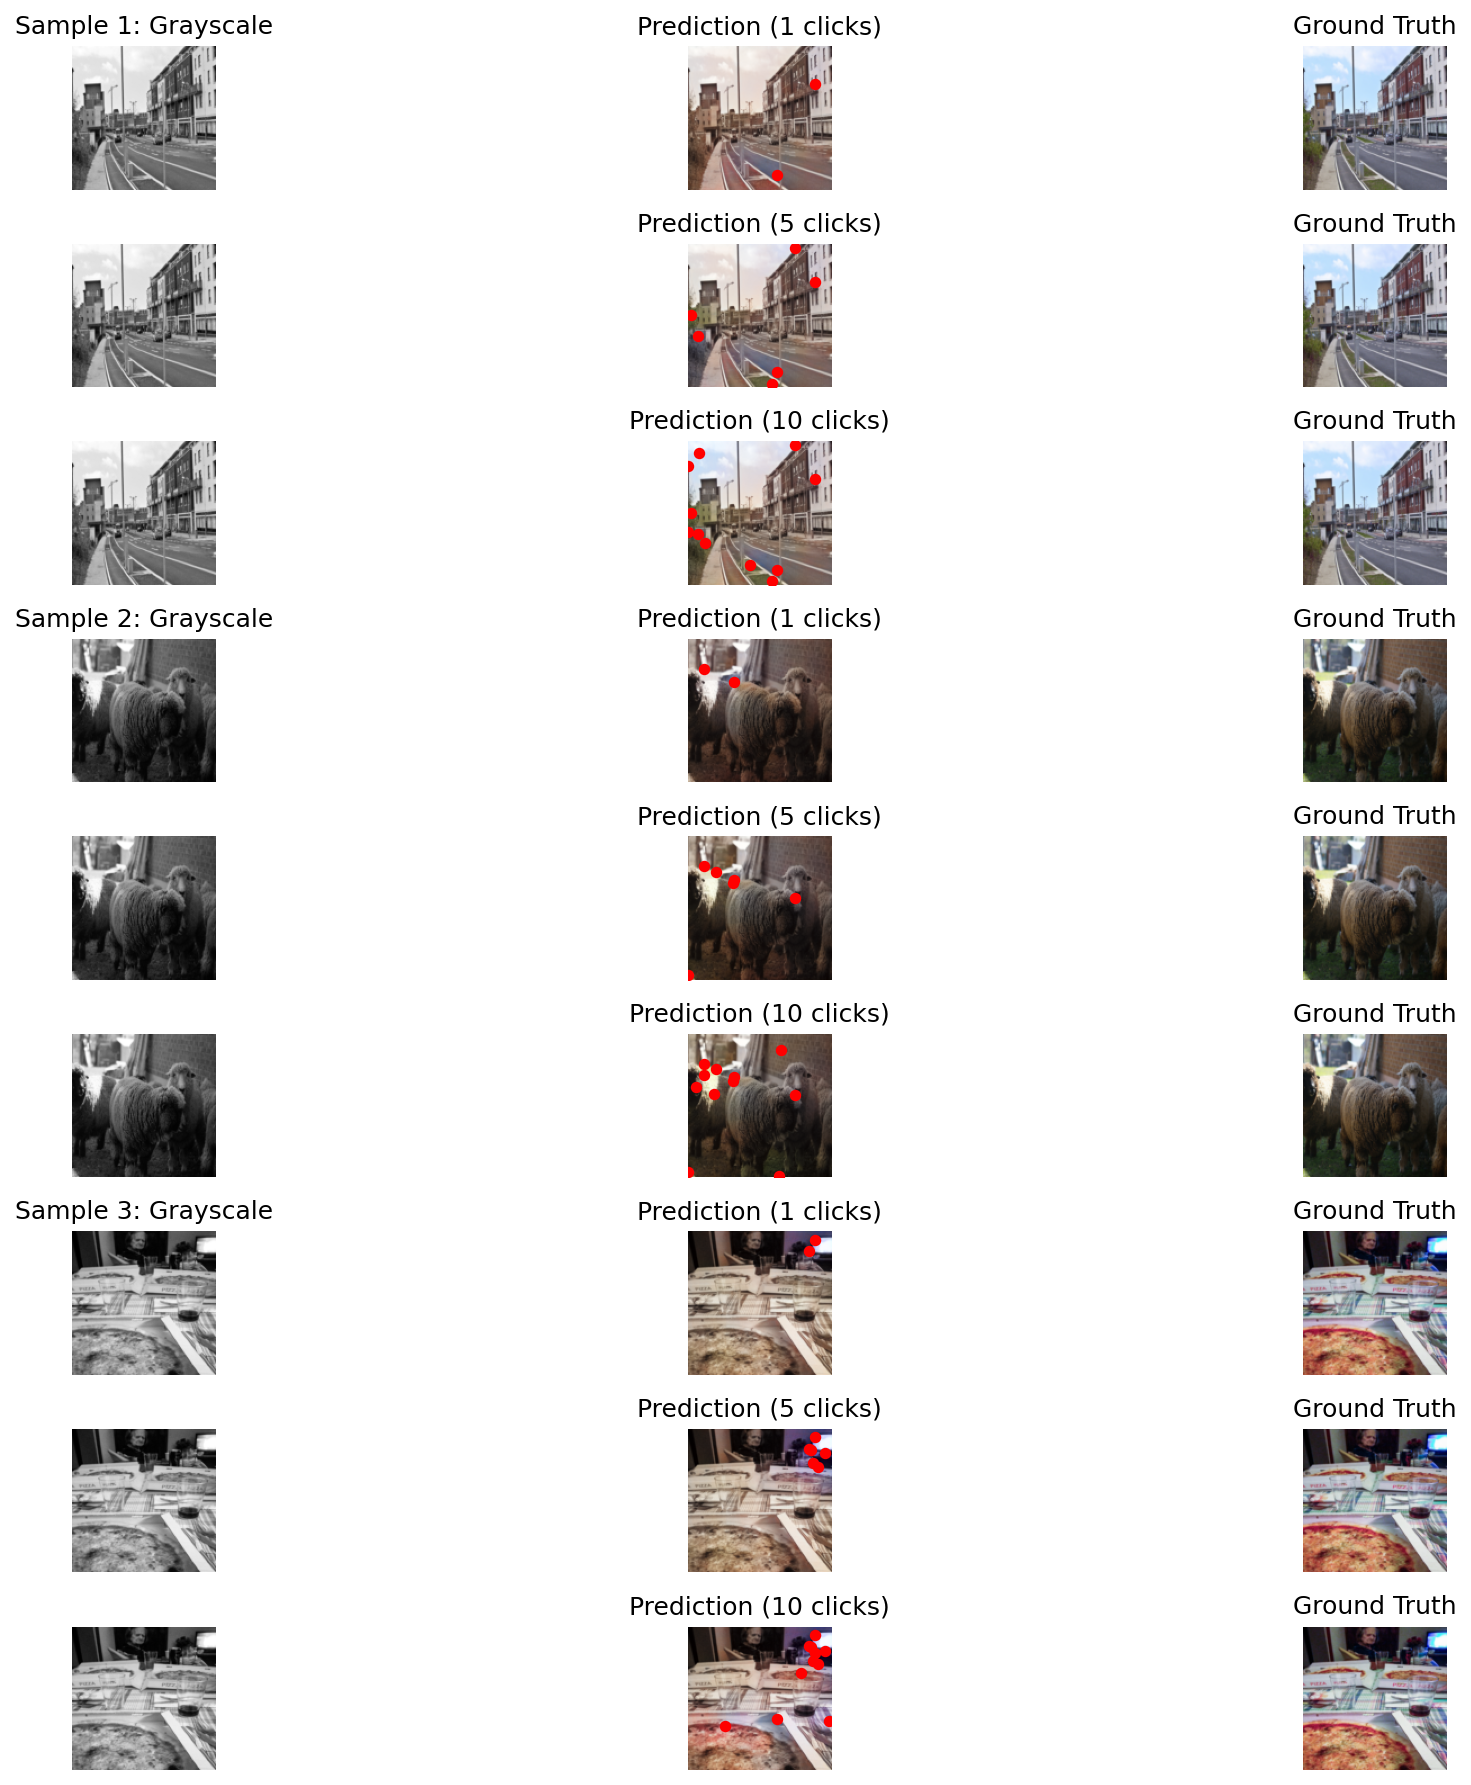

In [ ]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 4
    image_size = 128
    pretrain_color_epochs = 100
    pretrain_edit_epochs = 20
    pingpong_cycle = 5
    num_pingpong_cycles = 15
    
    train_dataset = CocoColorizationDataset(root_dir="data/coco/train2017", transform_size=image_size, limit=1000)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    val_dataset = CocoColorizationDataset(root_dir="data/coco/val2017", transform_size=image_size, limit=200)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    
    colornet = UNetColorNet7Level(in_channels=4, out_channels=2).to(device)
    editnet = EditNet(in_channels=5, out_channels=1).to(device)
    
    color_optimizer = optim.Adam(colornet.parameters(), lr=1e-3)
    edit_optimizer = optim.Adam(editnet.parameters(), lr=1e-4)
    criterion_mse = nn.MSELoss()

    best_psnr = -float('inf')
    
    print("=== Phase 1: Pretraining ColorNet ===")
    for epoch in range(pretrain_color_epochs):
        loss = train_color_net_epoch(colornet, train_loader, color_optimizer, device, criterion_mse, initial_clicks=50)
        if (epoch+1) % 10 == 0:
            psnr_val = evaluate_color_net(colornet, val_loader, device, criterion_mse, num_iterations=1, initial_clicks=50)
            print(f"Pretrain ColorNet Epoch {epoch+1}/{pretrain_color_epochs} - Loss: {loss:.4f}, PSNR: {psnr_val:.2f} dB")

            if psnr_val > best_psnr:
                best_psnr = psnr_val
                torch.save({'colornet': colornet.state_dict(),
                            'editnet': editnet.state_dict()},
                           "best_models.pth")
                print("Saved best models!")
    
    print("=== Phase 2: Pretraining EditNet ===")
    for epoch in range(pretrain_edit_epochs):
        loss = train_edit_net_epoch(colornet, editnet, train_loader, edit_optimizer, device, criterion_mse, threshold=0.3, initial_clicks=50)
        if (epoch+1) % 5 == 0:
            print(f"Pretrain EditNet Epoch {epoch+1}/{pretrain_edit_epochs} - Loss: {loss:.4f}")
    
    print("=== Phase 3: Ping Pong Training ===")
    for cycle in range(num_pingpong_cycles):
        print(f"--- Ping Pong Cycle {cycle+1} ---")

        for epoch in range(pingpong_cycle):
            loss = train_color_net_pingpong_epoch(colornet, editnet, train_loader, color_optimizer, device, criterion_mse, num_iterations=4, initial_clicks=50)
            psnr_val = evaluate_color_net(colornet, val_loader, device, criterion_mse, num_iterations=4, initial_clicks=50)
            print(f"Ping Pong ColorNet Epoch {epoch+1}/{pingpong_cycle} - Loss: {loss:.4f}, PSNR: {psnr_val:.2f} dB")
            if psnr_val > best_psnr:
                best_psnr = psnr_val
                torch.save({'colornet': colornet.state_dict(),
                            'editnet': editnet.state_dict()},
                           "best_models.pth")
                print("Saved best models!")
        
        for epoch in range(pingpong_cycle):
            loss = train_edit_net_pingpong_epoch(colornet, editnet, train_loader, edit_optimizer, device, criterion_mse, threshold=0.3, initial_clicks=50)
            print(f"Ping Pong EditNet Epoch {epoch+1}/{pingpong_cycle} - Loss: {loss:.4f}")
    print("Training finished!")
    
    visualize_results(colornet, editnet, dataset=val_dataset, device=device, n_samples=3, clicks_list=[1, 50, 100], max_clicks=100)

if __name__ == '__main__':
    main()
